**Executed:** Mon Oct  3 16:20:22 2016

**Duration:** 33 seconds.

# Signal vs spot

> *This notebook analysizes the signal intensity as a function of the excitation spot.*

## Import software

In [1]:
from fretbursts import *
sns = init_notebook()

 - Optimized (cython) burst search loaded.
 - Optimized (cython) photon counting loaded.


--------------------------------------------------------------
 You are running FRETBursts (version 0.5.9).

 If you use this software please cite the following paper:

   FRETBursts: An Open Source Toolkit for Analysis of Freely-Diffusing Single-Molecule FRET
   Ingargiola et al. (2016). http://dx.doi.org/10.1371/journal.pone.0160716 

--------------------------------------------------------------


In [2]:
import os
import pandas as pd
from IPython.display import display

In [3]:
figure_size = (5, 4)
default_figure = lambda: plt.subplots(figsize=figure_size)
save_figures = True

def savefig(filename, **kwargs):
    if not save_figures:
        return
    import os
    dir_ = 'figures/'
    kwargs_ = dict(dpi=300, bbox_inches='tight')
                   #frameon=True, facecolor='white', transparent=False)
    kwargs_.update(kwargs)
    plt.savefig(dir_ + filename, **kwargs_)

## Data files

In [4]:
data_dir = './data/2013-05-15/'

In [5]:
data_dir = os.path.abspath(data_dir) + '/'
assert os.path.exists(data_dir), "Path '%s' does not exist." % data_dir

In [6]:
from glob import glob
file_list = sorted(glob(data_dir + '*.hdf5'))

In [7]:
labels = ['7d', '12d', '17d', '22d', '27d', 'DO']
files_dict = {lab: fname for lab, fname in zip(sorted(labels), file_list)}
files_dict

{'12d': '/Users/anto/Google Drive/notebooks/multispot_paper/data/2013-05-15/12d_New_30p_320mW_steer_3.hdf5',
 '17d': '/Users/anto/Google Drive/notebooks/multispot_paper/data/2013-05-15/17d_100p_320mW_steer_1.hdf5',
 '22d': '/Users/anto/Google Drive/notebooks/multispot_paper/data/2013-05-15/22d_30p_320mW_steer_1.hdf5',
 '27d': '/Users/anto/Google Drive/notebooks/multispot_paper/data/2013-05-15/27d_50p_320mW_steer_1.hdf5',
 '7d': '/Users/anto/Google Drive/notebooks/multispot_paper/data/2013-05-15/7d_New_150p_320mW_steer_3.hdf5',
 'DO': '/Users/anto/Google Drive/notebooks/multispot_paper/data/2013-05-15/DO12_No2_50p_320mW_steer_1.hdf5'}

## Plot style

In [8]:
PLOT_DIR = './figure/'

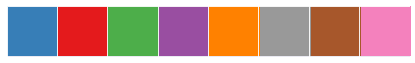

In [9]:
import matplotlib as mpl
from cycler import cycler

bmap = sns.color_palette("Set1", 9)
colors = np.array(bmap)[(1,0,2,3,4,8,6,7), :]
mpl.rcParams['axes.prop_cycle'] = cycler('color', colors)
colors_labels = ['blue', 'red', 'green', 'violet', 'orange', 'gray', 'brown', 'pink', ]
for c, cl in zip(colors, colors_labels):
    locals()[cl] = tuple(c) # assign variables with color names
sns.palplot(colors)

In [10]:
%config InlineBackend.figure_format='retina'  # for hi-dpi displays
sns.set(style='whitegrid', font_scale=1.4, palette=colors)
#palette = ('Paired', 10)
#sns.palplot(sns.color_palette(*palette))
#sns.set_palette(*palette)

# Load DCR

In [11]:
dcr = pd.DataFrame.from_csv('results/8-pixels_DCR.csv')
dcr.columns = ['D detector', 'A detector']
dcr

,D detector,A detector
CH,,
0,36.396964,3678.865963
1,116.553640,7203.520196
2,3774.853615,78.159763
3,566.996656,901.414458
4,29.229483,1716.534345
5,442.598405,4320.610497
6,27.127090,48.726782
7,24.438899,53.412143


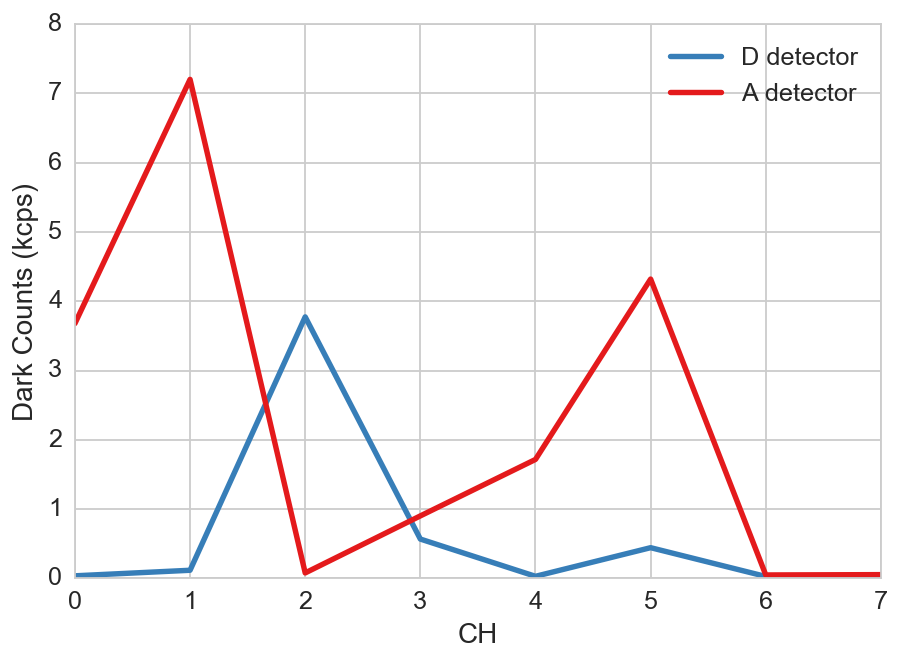

In [12]:
(dcr/1000).plot(lw=3);
plt.ylabel('Dark Counts (kcps)');

In [13]:
dcr_d = dcr.drop('A detector', axis=1)
dcr_a = dcr.drop('D detector', axis=1)

# Total Rates

In [14]:
df = pd.DataFrame(index=pd.Index(np.arange(1, 9), name='Spot'), 
                  columns=pd.Index(labels, name='Sample'))
raw_rates_d, raw_rates_a = df.copy(), df.copy()
for k in labels:
    d = loader.photon_hdf5(files_dict[k])
    t = d.acquisition_duration
    raw_rates = np.array([p.size/t for p in d.ph_times_m])
    raw_rates_a[k] = np.array([m.sum()/t for m in d.A_em])
    raw_rates_d[k] = raw_rates - raw_rates_a[k]

In [15]:
rates_a, rates_d = df.copy(), df.copy()
rates_a.iloc[:,:] = np.array(raw_rates_a) - np.array(dcr_a)
rates_d.iloc[:,:] = np.array(raw_rates_d) - np.array(dcr_d)

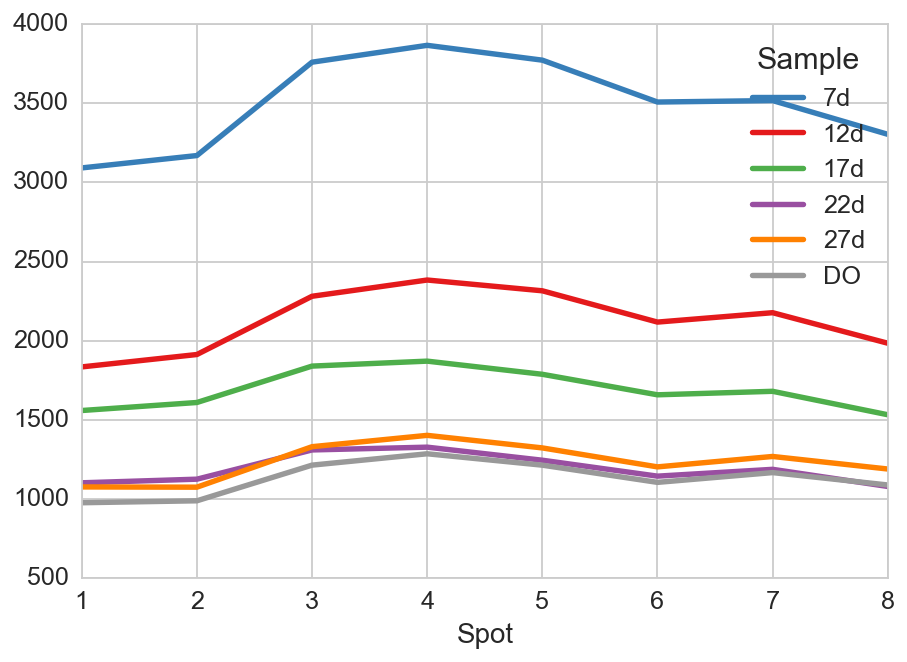

In [16]:
rates_a.plot(lw=3);

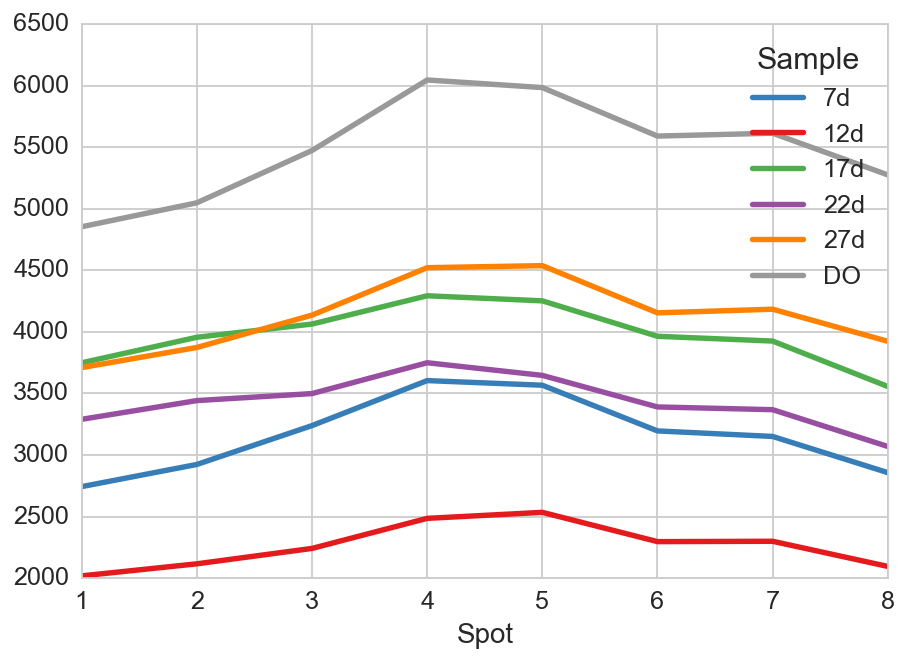

In [17]:
rates_d.plot(lw=3);

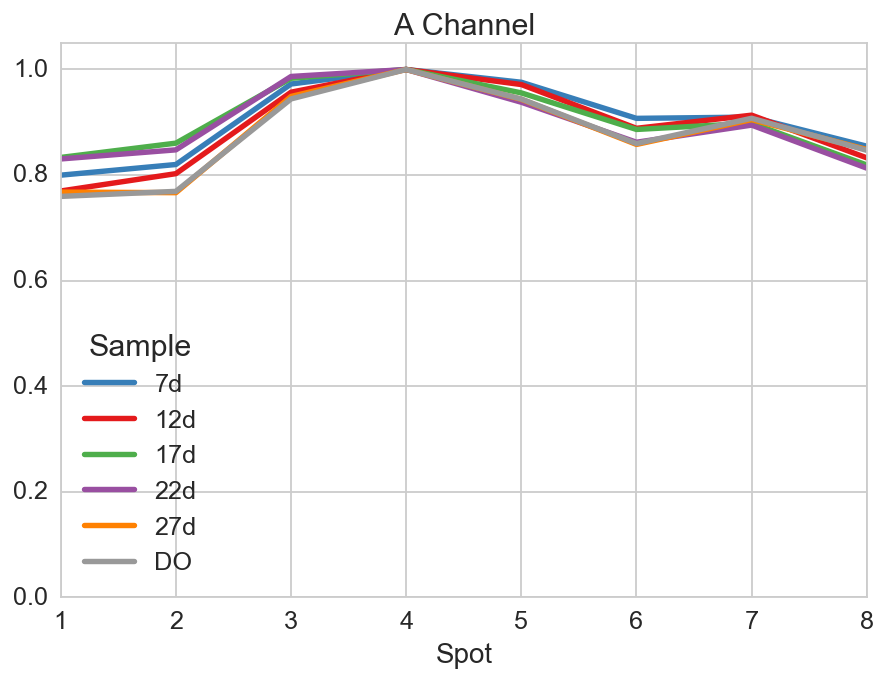

In [18]:
(rates_a / rates_a.max()).plot(lw=3);
plt.ylim(0);
plt.title('A Channel');

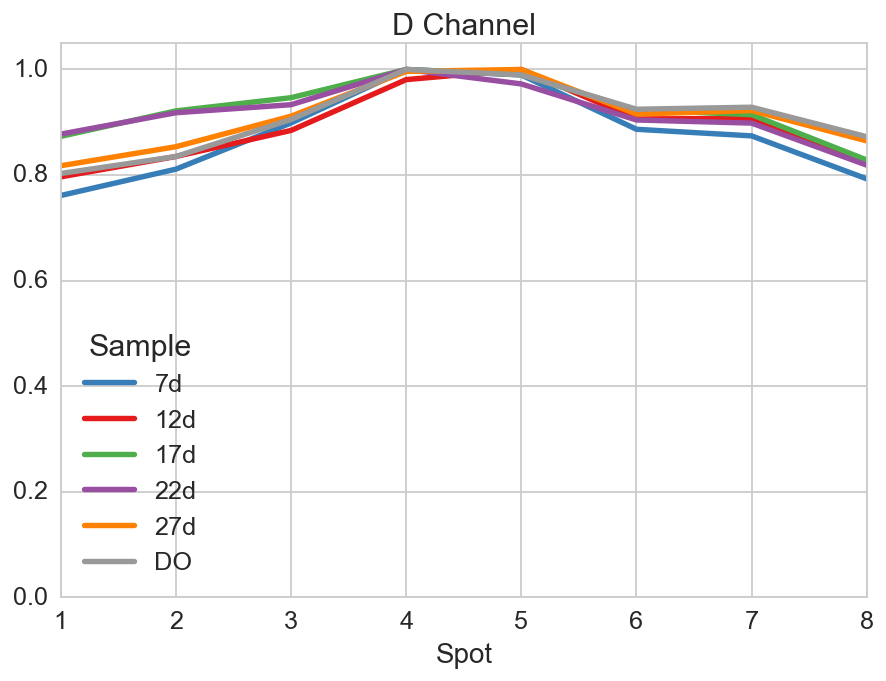

In [19]:
(rates_d / rates_d.max()).plot(lw=3);
plt.ylim(0);
plt.title('D Channel');

In [20]:
sns.set(font_scale=1.4, palette=colors)
sns.set_style('ticks')

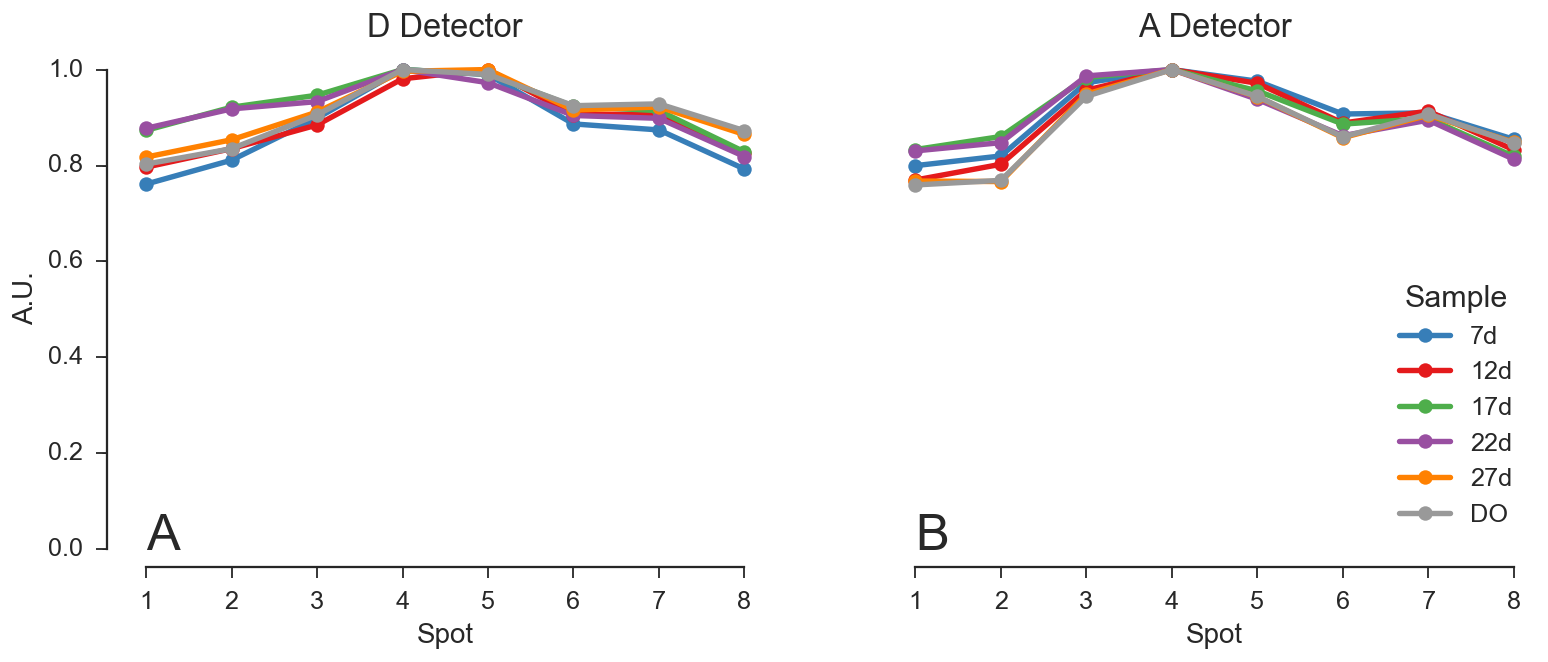

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5), sharey=True, sharex=True)
plt.subplots_adjust(wspace=0.2)
(rates_d / rates_d.max()).plot(lw=3, marker='o', ms=8, ax=ax[0]);
(rates_a / rates_a.max()).plot(lw=3, marker='o', ms=8, ax=ax[1]);
plt.ylim(0);

ax[0].set_title('D Detector', fontsize=18);
ax[1].set_title('A Detector', fontsize=18);
sns.despine(offset=10, trim=True, ax=ax[0])
sns.despine(offset=10, trim=True, ax=ax[1], left=True)
ax[1].yaxis.set_visible(False)
ax[0].set_ylabel('A.U.')
plt.xlim(0.75, 8.25)
ax[1].legend(loc='lower right', title='Sample')
ax[0].legend_.remove()
fs = 28
ax[0].text(1,0, 'A', fontsize=fs)
ax[1].text(1,0, 'B', fontsize=fs)
savefig('5dsDNA signal vs ch.png')

In [22]:
rates1 = rates_d.copy()
rates1.columns = ['D %s' % c for c in rates1.columns]
rates2 = rates_a.copy()
rates2.columns = ['A %s' % c for c in rates2.columns]
rates_da = pd.concat([rates1, rates2], axis=1)

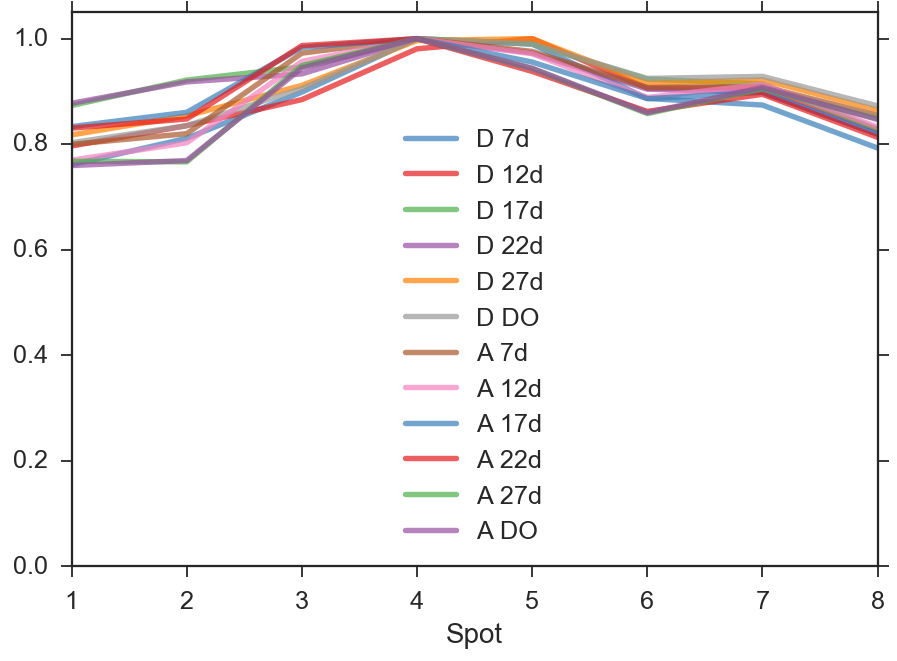

In [23]:
(rates_da / rates_da.max()).plot(lw=3, alpha=0.7);
plt.ylim(0);

In [24]:
rates = rates_d + rates_a

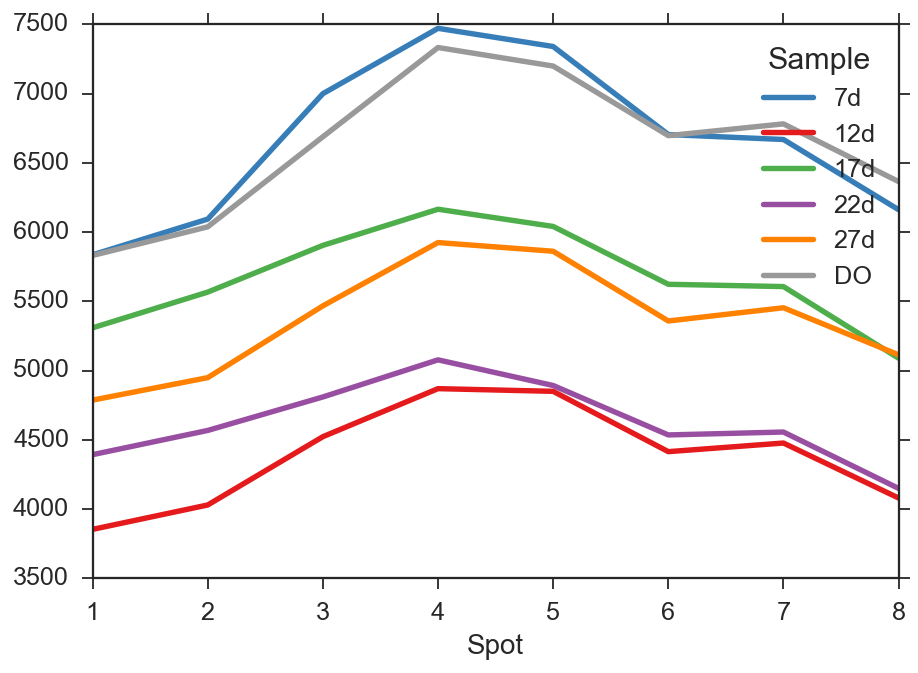

In [25]:
rates.plot(lw=3);

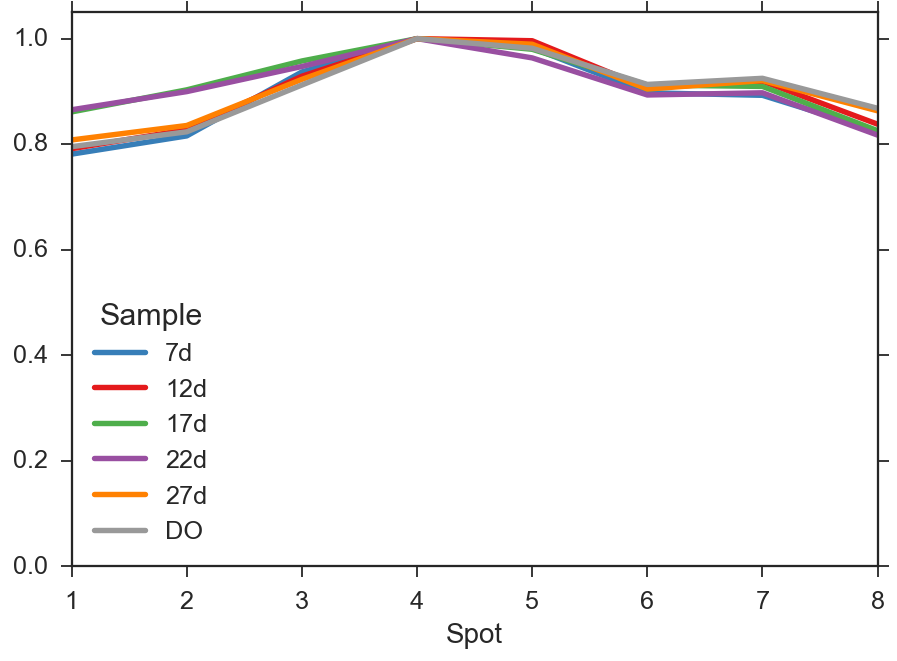

In [26]:
(rates / rates.max()).plot(lw=3);
plt.ylim(0);

# Background rates

In [27]:
df = pd.DataFrame(index=np.arange(8), columns=labels)
df.index.name = 'CH'
df.columns.name = 'sample'
raw_bg_rates_d, raw_bg_rates_a = df.copy(), df.copy()
for k in labels:
    d = loader.photon_hdf5(files_dict[k])
    d.calc_bg(fun=bg.exp_fit, time_s=30, tail_min_us='auto', F_bg=1.7)
    raw_bg_rates_d[k] = np.asfarray(d.bg_dd).mean(1)
    raw_bg_rates_a[k] = np.asfarray(d.bg_ad).mean(1)

 - Calculating BG rates ... 

[DONE]


 - Calculating BG rates ... 

[DONE]


 - Calculating BG rates ... 

[DONE]


 - Calculating BG rates ... 

[DONE]


 - Calculating BG rates ... 

[DONE]


 - Calculating BG rates ... 

[DONE]


In [28]:
bg_rates_a, bg_rates_d = df.copy(), df.copy()
bg_rates_a.iloc[:,:] = np.array(raw_bg_rates_a) - np.array(dcr_a)
bg_rates_d.iloc[:,:] = np.array(raw_bg_rates_d) - np.array(dcr_d)

(0, 3500)

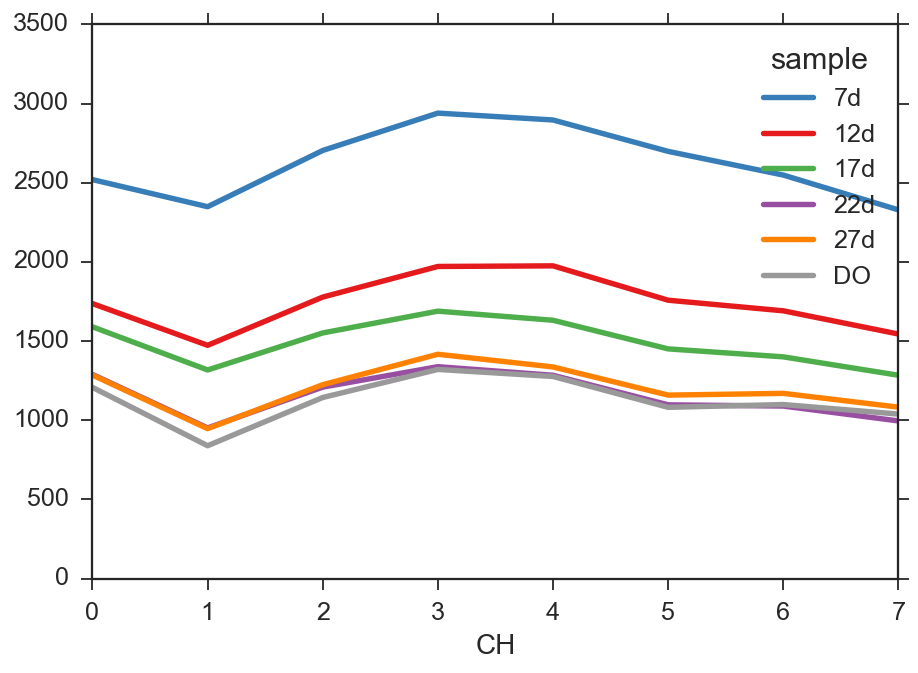

In [29]:
bg_rates_a.plot(lw=3);
plt.ylim(0, 3500)

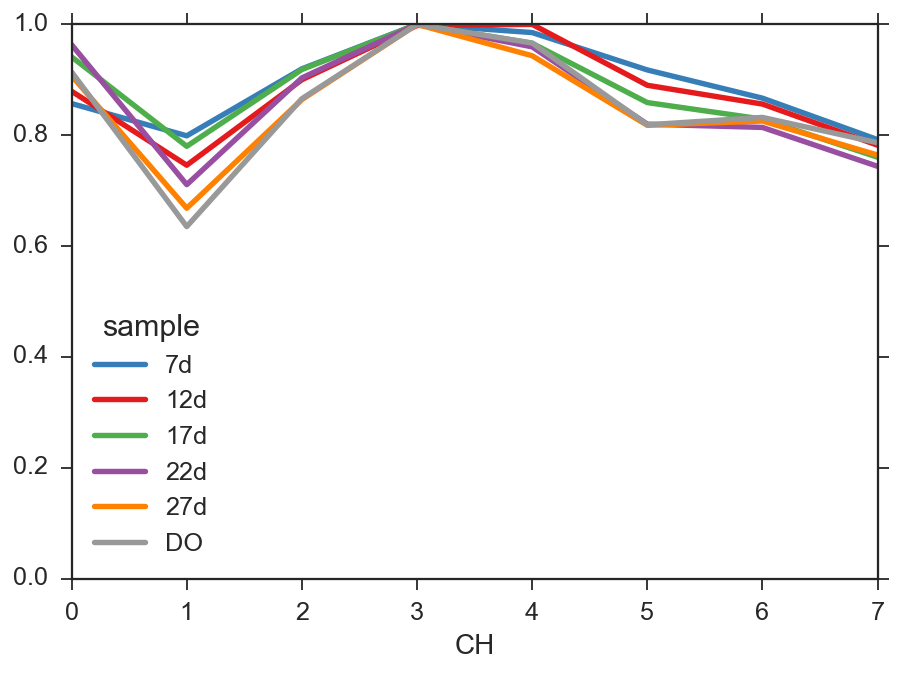

In [30]:
(bg_rates_a / bg_rates_a.max()).plot(lw=3);
plt.ylim(0);

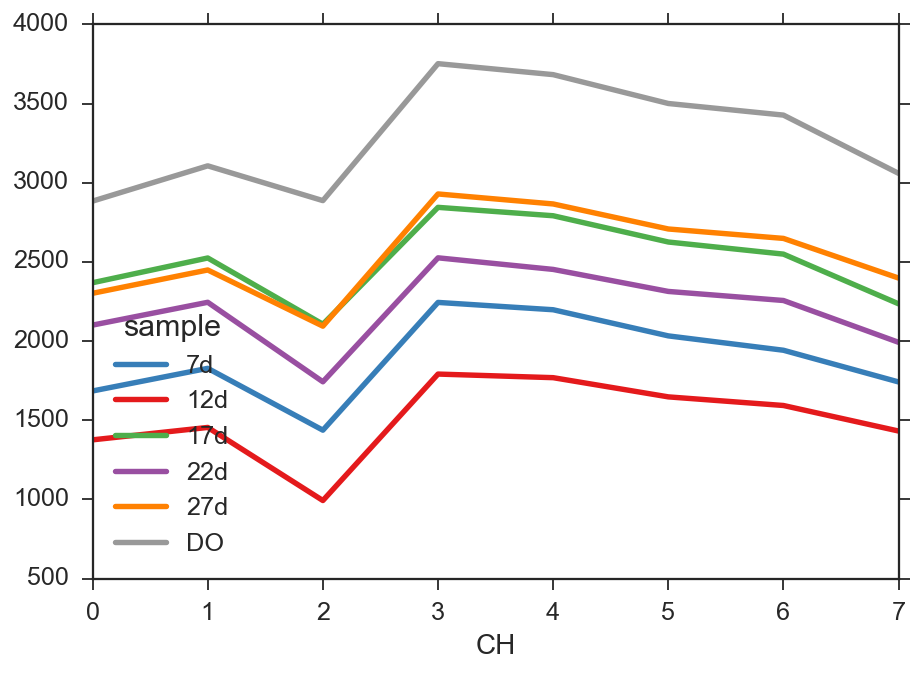

In [31]:
bg_rates_d.plot(lw=3);

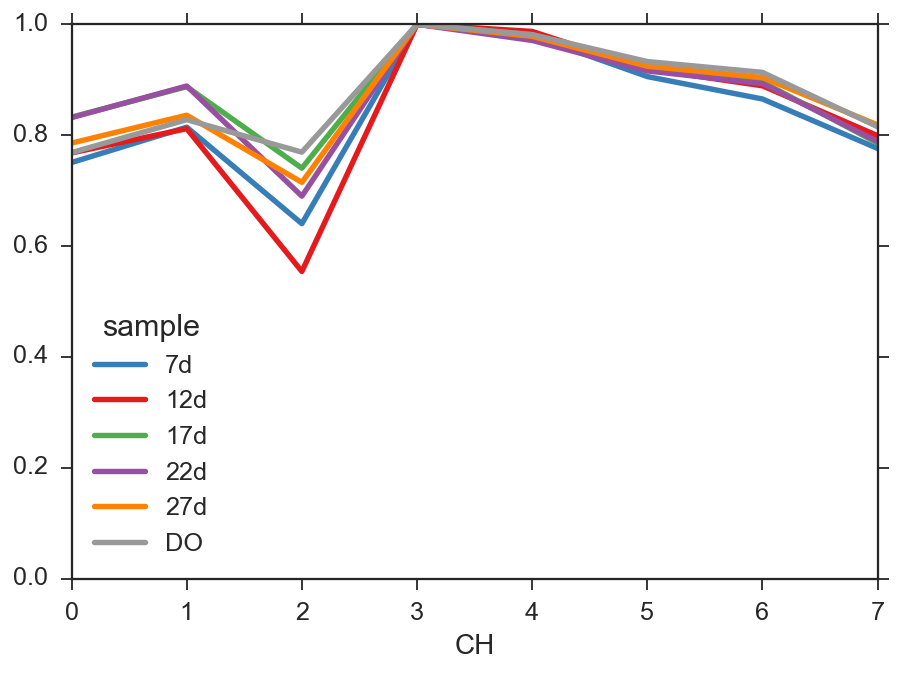

In [32]:
(bg_rates_d / bg_rates_d.max()).plot(lw=3);
plt.ylim(0);

In [33]:
bg_rates = bg_rates_d + bg_rates_a

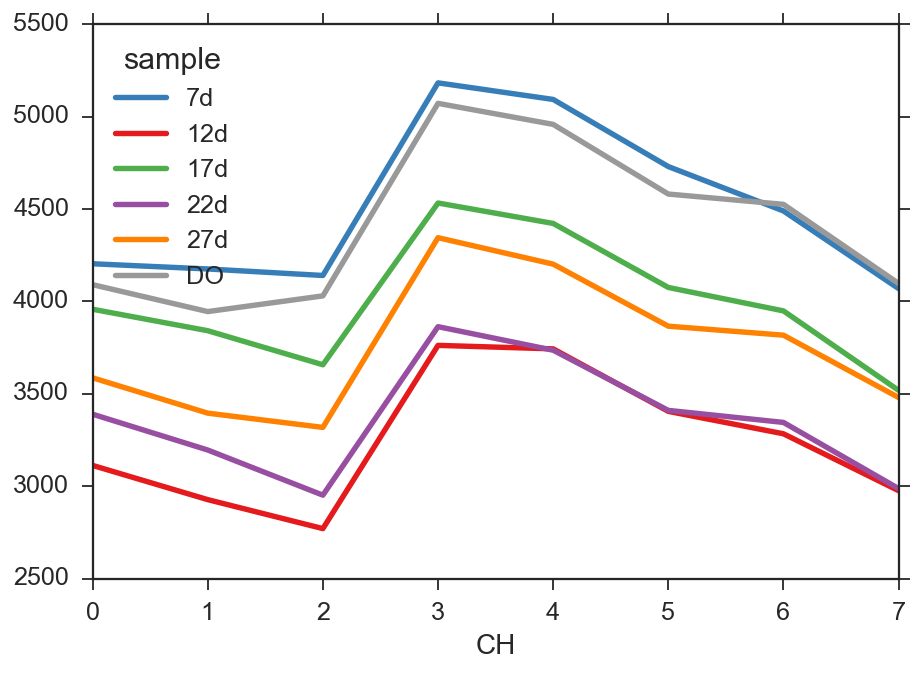

In [34]:
bg_rates.plot(lw=3);

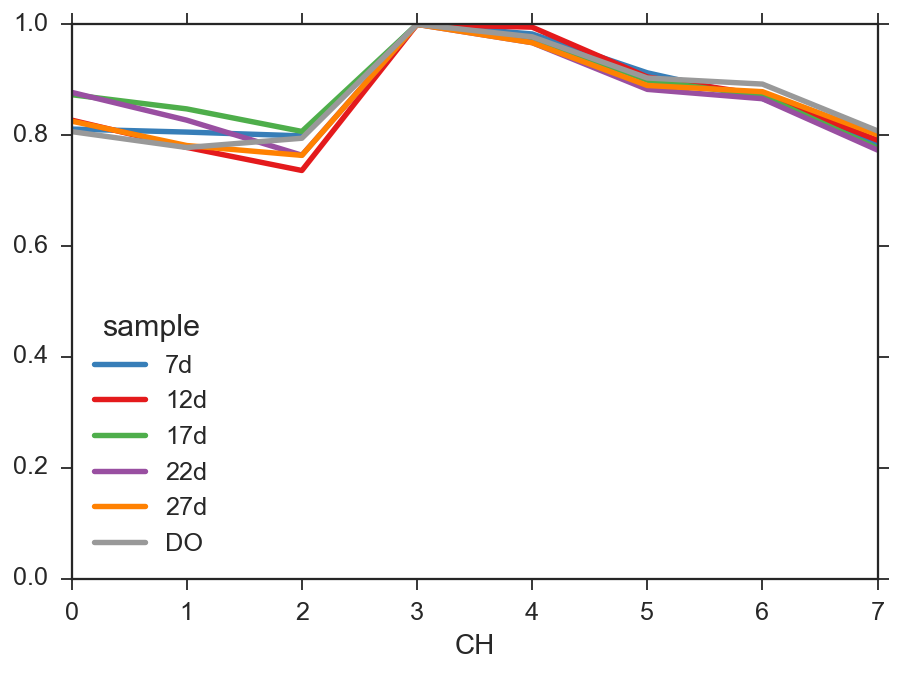

In [35]:
(bg_rates / bg_rates.max()).plot(lw=3);
plt.ylim(0);